In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
order_line_color = colors[6]
colors = colors[:6] + colors[7:]

def style_plot(fig, ax, aspect="equal", label_fontsize=20, no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect == "equal":
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels(minor=True) + ax.get_yticklabels(minor=True):
        label.set_fontweight('bold')
        label.set_fontsize(label_fontsize)

    for label in (ax.get_xticklabels(minor=False) + ax.get_yticklabels(minor=False)):
        label.set_fontweight('bold')
        label.set_fontsize(label_fontsize)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')

In [17]:
class Renormalization:

    def __init__(self, g, partition_type="by_tile", num_patches_per_dim=None, autoplot=True):

        self.g = g
        self.partition_type = partition_type

        if self.partition_type == "by_patch":
            self.num_patches_per_dim = num_patches_per_dim
            self.num_patches = self.num_patches_per_dim**2
            self.patch_side_length = 1.0 / self.num_patches_per_dim
        elif self.partition_type == "by_tile":
            self.num_patches = (self.g.num_horizontal_displacements 
                                * self.g.num_vertical_displacements)

        self.super_V_coords, self.patch_coords, self.V_to_super_V, self.translations = self.partition_graph()
        self.E_data = self.construct_E_data()

        if autoplot:
            self.plot_patching(figsize=5)

    def __call__(self, calculation="full"):

        if calculation == "full":

            alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

            Q = [np.zeros((2, 2)) for _ in range(self.num_patches)]
            T = [0 for _ in range(self.num_patches)]

            for v, w in self.E_data:

                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                alpha_v = np.array([alpha_x[v], alpha_y[v]])
                alpha_w = np.array([alpha_x[w], alpha_y[w]])

                fac = (r_ij + alpha_w - alpha_v)

                T[self.V_to_super_V[v]["patch_num"]] += l_vw
                Q[self.V_to_super_V[v]["patch_num"]] += fac[:, None] @ fac[None, :] / l_vw

        return Q, T
    
    def solve_for_bilinear_coefficients(self, return_all=False):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            C[v, w] -= 1 / l_vw
            C[v, v] += 1 / l_vw
                
            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        alpha_x = sparseqr.solve(C, Dx) #, tolerance = 1e-9)
        alpha_y = sparseqr.solve(C, Dy) #, tolerance = 1e-9)

        print(f"error_x = {np.linalg.norm(C @ alpha_x - Dx)}")
        print(f"error_y = {np.linalg.norm(C @ alpha_y - Dy)}")

        if return_all:
            return C, alpha_x, alpha_y, Dx, Dy
        return alpha_x, alpha_y

    def partition_graph(self):
        
        super_V_coords = []
        V_to_super_V = {}
        super_V_to_V = collections.defaultdict(list)
        patch_coords = []

        if self.partition_type == "by_tile":

            tile_num = -1
            for row in range(self.g.num_vertical_displacements):
                for col in range(self.g.num_horizontal_displacements):
                    tile_num += 1
                    v_indices = np.arange(tile_num * self.g.num_Vs_for_tile, (tile_num + 1) * self.g.num_Vs_for_tile)
                    tile = self.g.V_coords[v_indices]
                    super_V_coords.append(np.mean(tile, axis=0))
                    for v_index in v_indices:
                        V_to_super_V[v_index] = {"patch_num": tile_num, 
                                                 "patch_indices": np.array([col, row])}

            # Calculate x, y translations by looking at displacements between tiles
            max_displacement = np.max([self.g.horizontal_displacement, self.g.vertical_displacement])
            horizonal_displacement = (self.g.horizontal_displacement / max_displacement 
                                      / self.g.num_horizontal_displacements)
            vertical_displacement = (self.g.vertical_displacement / max_displacement 
                                     / self.g.num_vertical_displacements)

            translations = np.array([horizonal_displacement, vertical_displacement])

        elif self.partition_type == "by_patch": 

            # Create the patch_coords
            for row in range(self.num_patches_per_dim):
                for col in range(self.num_patches_per_dim):
                    center_x = (col + 0.5) * self.patch_side_length
                    center_y = (row + 0.5) * self.patch_side_length
                    patch_coords.append([center_x, center_y])
            patch_coords = np.array(patch_coords)

            # Assign each vertex to the corresponding patch
            for v_num, (x, y) in enumerate(self.g.V_coords):
                patch_col = np.floor(x / self.patch_side_length).astype(int)
                patch_row = np.floor(y / self.patch_side_length).astype(int)
                patch_num = patch_row * self.num_patches_per_dim + patch_col
                V_to_super_V[v_num] = {"patch_num": patch_num, 
                                       "patch_indices": np.array([patch_col, patch_row])}
                super_V_to_V[patch_num].append(v_num)
                
            # Create super_V_coords
            super_V_coords = []
            for patch_num in range(self.num_patches):
                if self.g.V_coords[super_V_to_V[patch_num]].size == 0:
                    super_V_coords.append(None)
                else:
                    super_V_coords.append(np.mean(self.g.V_coords[super_V_to_V[patch_num]], axis=0))
            # super_V_coords = np.array(super_V_coords)  

            self.super_V_to_V = super_V_to_V      

            translations = np.array([self.patch_side_length, self.patch_side_length])

        return super_V_coords, patch_coords, V_to_super_V, translations
    
    def construct_E_data(self):

        E_data = {}

        if self.partition_type == "by_tile":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges:
                    a, b = (v % self.g.num_Vs_for_tile), (w % self.g.num_Vs_for_tile) 

                    if (a, b) in self.g.connectivity_map: 
                        r_ij = np.array(self.g.directions[self.g.connectivity_map[a, b][0]['direction']])
                    else: 
                        r_ij = -np.array(self.g.directions[self.g.connectivity_map[b, a][0]['direction']])
                    r_ij = r_ij * self.translations
                else:
                    i, j = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j] - self.super_V_coords[i]

                E_data[v, w]["r_ij"] = r_ij

        elif self.partition_type == "by_patch":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: 

                    i_index = self.V_to_super_V[v]["patch_indices"].copy()
                    j_index = self.V_to_super_V[w]["patch_indices"].copy()
                    ji_ind_dif = j_index - i_index
                    patch_i_coords = self.super_V_coords[self.V_to_super_V[v]["patch_num"]].copy()
                    patch_j_coords = self.super_V_coords[self.V_to_super_V[w]["patch_num"]].copy()

                    if ji_ind_dif[0] == self.num_patches_per_dim - 1:
                        patch_j_coords[0] -= 1
                    elif ji_ind_dif[0] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[0] += 1
                    if ji_ind_dif[1] == self.num_patches_per_dim - 1:
                        patch_j_coords[1] -= 1
                    elif ji_ind_dif[1] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[1] += 1

                    r_ij = patch_j_coords - patch_i_coords

                else:
                    i_num, j_num = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

                E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def plot_patching(self, figsize=10, linewidth=2,
                      return_figax=False, plot_V_nums=False):
        
        if self.partition_type == "by_tile":
            raise ValueError("Plotting for partitioning by tile not yet implemented")

        fig, ax = self.g.plot_graph(return_figax=True, figsize=figsize, linewidth=linewidth)
        for center in self.patch_coords:
            bottom_corner = (center[0] - self.patch_side_length / 2, center[1] - self.patch_side_length / 2)
            square = matplotlib.patches.Rectangle(bottom_corner, self.patch_side_length, self.patch_side_length,
                                                  linewidth=2 * linewidth, 
                                                  edgecolor='r', facecolor=(0.8, 0.8, 0.8, 0.1), alpha=1)
            ax.add_patch(square)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        if plot_V_nums:
            for v_num, v_coord in enumerate(self.g.V_coords):
                ax.annotate(str(v_num), v_coord, fontsize=20)

        if return_figax:
            return fig, ax
        plt.show()

In [18]:
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                    num_Vs_for_tile=20,
                                    num_horizontal_displacements=1, 
                                    num_vertical_displacements=1,
                                    autoplot=False)

In [19]:
g.periodic_edges

{(3,
  16): array([[0.57728401, 0.16967812],
        [1.00159457, 0.14545014]]),
 (8,
  13): array([[0.46185344, 0.72624328],
        [0.26798868, 1.06188917]]),
 (6,
  8): array([[0.13159685, 1.03921054],
        [0.46185344, 0.72624328]]),
 (9,
  13): array([[0.4748717 , 0.90405082],
        [0.26798868, 1.06188917]]),
 (6,
  11): array([[0.13159685, 1.03921054],
        [0.33851449, 0.57749619]]),
 (12,
  16): array([[0.85273616, 0.35020195],
        [1.00159457, 0.14545014]]),
 (7,
  12): array([[1.02523183, 0.27155029],
        [0.85273616, 0.35020195]]),
 (15,
  16): array([[0.5715502 , 0.98355542],
        [1.00159457, 1.14545014]]),
 (3,
  15): array([[0.57728401, 1.16967812],
        [0.5715502 , 0.98355542]]),
 (13,
  15): array([[0.26798868, 1.06188917],
        [0.5715502 , 0.98355542]]),
 (6,
  17): array([[1.13159685, 1.03921054],
        [0.77911099, 0.80512749]]),
 (16,
  17): array([[1.00159457, 1.14545014],
        [0.77911099, 0.80512749]]),
 (4,
  17): array([[1.159

In [16]:
next_Qs = {}

N = 1
num_Vs_for_tile  = 1000
seed = 0
Qs_for_num_Vs = []

np.random.seed(seed)
print(seed)
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                    num_Vs_for_tile=num_Vs_for_tile,
                                    num_horizontal_displacements=N, 
                                    num_vertical_displacements=N,
                                    autoplot=False)
print("Graph constructed.")
R = Renormalization(g, partition_type="by_tile", autoplot=False)

print("Renormalization constructed.")
Q, T = R()
C, alpha_x, alpha_y, Dx, Dy = R.solve_for_bilinear_coefficients(return_all=True)
print("Renormalization calculated.")
Qs = []
for i, j in zip(Q, T):
    if np.abs(j) > 1e-13:
        Qs.append(i / j)
Qs_for_num_Vs.append(np.trace(Qs[0])**0.5)
next_Qs[num_Vs_for_tile] = Qs_for_num_Vs.copy()
print(next_Qs[num_Vs_for_tile])
print()

0
Graph constructed.
Renormalization constructed.
error_x = 3.5364366499548923e-12
error_y = 3.0469732923207845e-12
error_x = 3.5364366499548923e-12
error_y = 3.0469732923207845e-12
Renormalization calculated.
[0.921590795505166]



In [15]:
next_Qs

{1000: [0.9599952059803039]}

In [220]:
np.linalg.norm((C @ np.ones((1000, 1)))[:-1])

6.41429639820167e-13

In [194]:
nums_Vs_for_tile = (10**np.linspace(1.7, 4, 30)).astype(int)
print(nums_Vs_for_tile)
num_seeds = 1 #32
N = 1

[   50    60    72    86   104   124   149   179   216   259   311   373
   448   538   646   775   931  1117  1341  1610  1932  2320  2785  3343
  4012  4816  5781  6940  8330 10000]


In [11]:
next_Qs = {}

for num_Vs_for_tile in [1000]:#nums_Vs_for_tile[:19]:
    print(num_Vs_for_tile)
    Qs_for_num_Vs = []
    if num_Vs_for_tile < 5000:
        max_seed = 1
    elif num_Vs_for_tile > 10000:
        max_seed = 1
    else:
        max_seed = 1
    for seed in range(max_seed):
        np.random.seed(seed)
        print(seed)
        g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                            num_Vs_for_tile=num_Vs_for_tile,
                                            num_horizontal_displacements=N, 
                                            num_vertical_displacements=N,
                                            autoplot=False)
        print("Graph constructed.")
        R = Renormalization(g, "by_tile", autoplot=False, free=True)
        print("Renormalization constructed.")
        Q, T = R()
        print("Renormalization calculated.")
        Qs = []
        for i, j in zip(Q, T):
            if np.abs(j) > 1e-13:
                Qs.append(i / j)
        Qs_for_num_Vs.append(np.trace(Qs[0])**0.5)
    next_Qs[num_Vs_for_tile] = Qs_for_num_Vs.copy()
    print(next_Qs[num_Vs_for_tile])
    print()

1000
0
Graph constructed.
Renormalization constructed.
error_x = 1.1391596008998147e-10
error_y = 8.056624859437043e-11
Renormalization calculated.
[43.33149892493368]



In [135]:
# file = open("/Users/sidneyholden/repos/metric_graph/test_scripts/Qs_data.pkl", "rb")
# full_Qs = pickle.load(file)
# file.close()

# file = open("/Users/sidneyholden/repos/metric_graph/test_scripts/final_Qs_data.pkl", "wb")
# pickle.dump(full_Qs, file)
# file.close()

# file = open("/Users/sidneyholden/repos/metric_graph/data/tiling/random_delaunay_triangulation_periodic/eigenvalue_data_backup.pkl", "rb")
file = open("eigs_data.pkl", "rb")
eigenvalues = pickle.load(file)
file.close()

In [296]:
eigenvalues

{50: [array([3.88997714, 4.12486084, 4.27122877, 4.59874476]),
  array([3.83736609, 3.95834166, 4.4618325 , 4.58008755]),
  array([3.6346415 , 4.1177327 , 4.51220387, 4.56544502]),
  array([3.93427592, 4.12992223, 4.29121637, 4.42071117]),
  array([3.81251626, 3.99551452, 4.40577327, 4.700957  ]),
  array([3.83147222, 3.99253118, 4.33321466, 4.42063146]),
  array([4.09656808, 4.17820852, 4.27313128, 4.3375053 ]),
  array([3.95764557, 3.98280796, 4.21287355, 4.45656529]),
  array([3.86536135, 4.07186677, 4.34633534, 4.52749557]),
  array([3.96960757, 4.13596972, 4.26550893, 4.48070494]),
  array([3.84693839, 4.15436871, 4.30255383, 4.41563078]),
  array([3.81407241, 4.19319104, 4.28078624, 4.56346168]),
  array([3.8524782 , 4.00717337, 4.33120363, 4.79083426]),
  array([3.75245287, 4.12978735, 4.28660136, 4.68869043]),
  array([3.7684437 , 4.14087828, 4.37098624, 4.53636939]),
  array([4.01363669, 4.04950251, 4.30063503, 4.65534787]),
  array([4.03333948, 4.14977523, 4.20704093, 4.46673

In [308]:
means_Qs = []
means_eigs = []
std_Qs = []
std_eigs = []
for num_Vs_for_tile in nums_Vs_for_tile:
    
    data_Qs = np.array(full_Qs[num_Vs_for_tile])**2
    # data_eigs = np.mean(np.array(eigenvalues[num_Vs_for_tile]), axis=1)

    means_Qs.append(np.mean(data_Qs))
    # means_eigs.append(np.mean(data_eigs))

    std_Qs.append(np.std(data_Qs))
    # std_eigs.append(np.std(data_eigs))

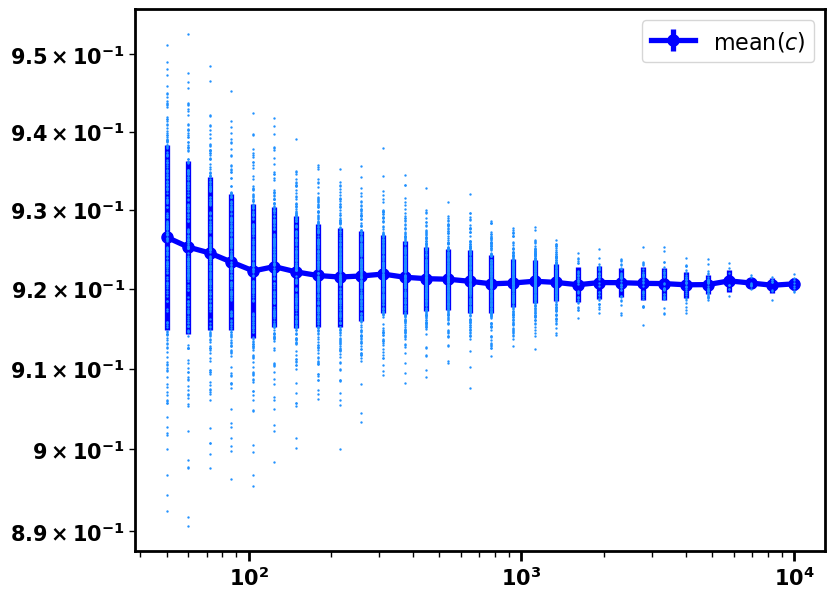

In [314]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(nums_Vs_for_tile, means_Qs, yerr=std_Qs, c='b', fmt='o-', markersize=8, label='mean($c$)', linewidth=3.8, zorder=1)

for num_Vs_for_tile in nums_Vs_for_tile:
    y = np.array(full_Qs[num_Vs_for_tile])**2
    x = num_Vs_for_tile * np.ones(len(y))
    ax.scatter(x, y, s=0.5, c='dodgerblue',zorder=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=16)

style_plot(fig, ax, aspect=None, label_fontsize=15)

plt.savefig("/Users/sidneyholden/repos/metric_graph/data/tiling/random_delaunay_triangulation_periodic/c_convergence.png", dpi=200, bbox_inches="tight")
plt.show()

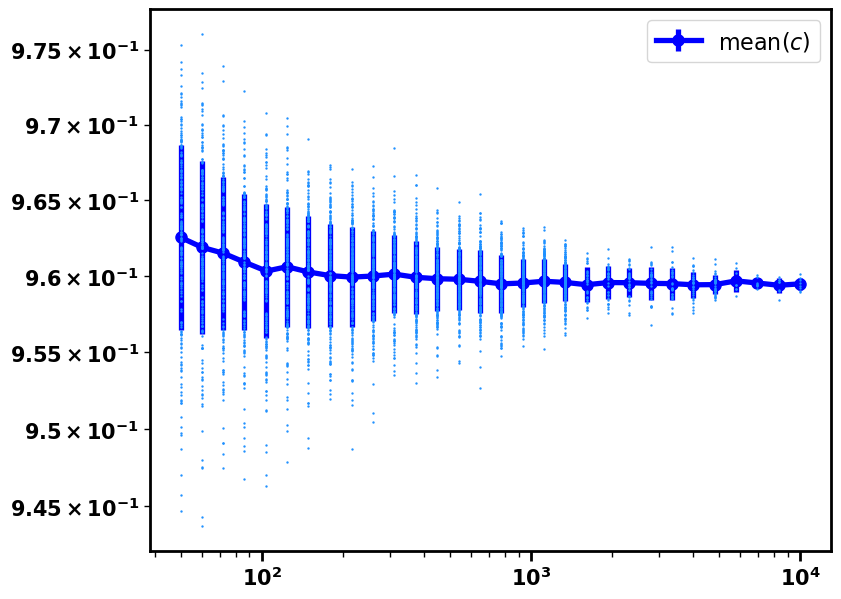

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(nums_Vs_for_tile, means_Qs, yerr=std_Qs, c='b', fmt='o-', markersize=8, label='mean($c$)', linewidth=3.8, zorder=1)

for num_Vs_for_tile in nums_Vs_for_tile:
    y = full_Qs[num_Vs_for_tile]
    x = num_Vs_for_tile * np.ones(len(y))
    ax.scatter(x, y, s=0.5, c='dodgerblue',zorder=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=16)

style_plot(fig, ax, aspect=None, label_fontsize=15)

plt.savefig("/Users/sidneyholden/repos/metric_graph/data/tiling/random_delaunay_triangulation_periodic/c_convergence.png", dpi=200, bbox_inches="tight")
plt.show()

In [153]:
c = 0.9594902707114124

In [313]:
0.9594902707114124**2

0.9206215795898594

In [290]:
mean_difs = []
std_difs = []

for num_Vs_for_tile in nums_Vs_for_tile:
    
    data_eigs = np.mean(np.array(eigenvalues[num_Vs_for_tile]), axis=1)

    continuum_eig = c * calculate_pde_eigenvalues(1, 0)
    difs = np.abs((data_eigs - continuum_eig) / continuum_eig)

    mean_difs.append(np.mean(difs))
    std_difs.append(np.std(difs))

In [257]:
def plot_loglog_rel_err(Num_Vs, rel_errs, plot_order_line=True, show_legend=False, rate_slope=0.5, rate_scaling=1):
    

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111)

    # Separate data by size
    for en, rel_err in enumerate(rel_errs):
        ax.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])

    if plot_order_line:
        # Setup convergence line
        order_line_data = 1/5 * Num_Vs**(-0.5)
        ax.loglog(Num_Vs, order_line_data, 
                linewidth=4, c='r')

    style_plot(fig, ax, aspect=None, no_xticks=True)

    return fig, fig.axes

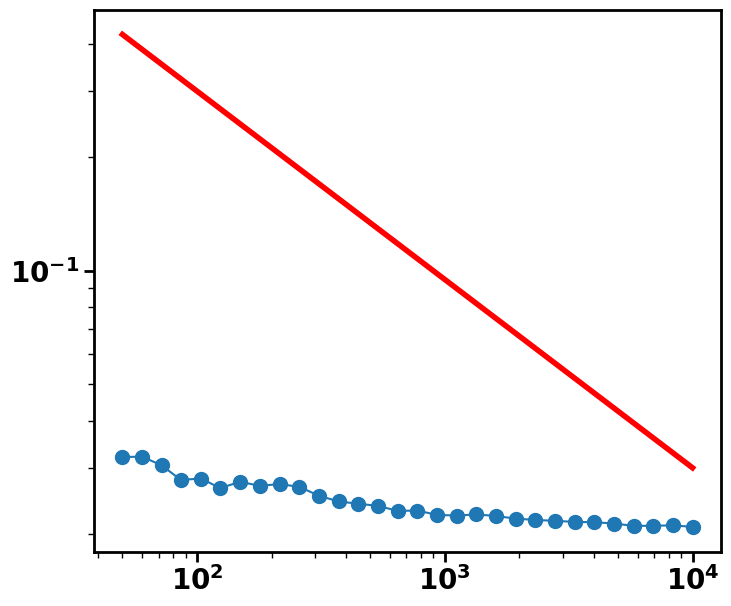

In [291]:
fig, ax = plot_loglog_rel_err(nums_Vs_for_tile, np.array([mean_difs]))
ax = ax[0]
ax.tick_params(axis='x', which='major', length=7, width=2, direction='out')
ax.tick_params(axis='y', which='major', length=7, width=2, direction='out')
ax.tick_params(axis='x', which='minor', length=4, width=1, direction='out')
ax.tick_params(axis='y', which='minor', length=4, width=1, direction='out')

save_file_name = ("/Users/sidneyholden/repos/metric_graph/data/tiling/random_delaunay_triangulation_periodic" + 
                  "/uniform_delaunay_tiling_eigenvalue_relerr.png")

plt.savefig(save_file_name, dpi=200, bbox_inches='tight')

## Eigenfunction calculations

In [246]:
efunc_rel_errs = {}

continuum_eigendata = solve_laplace_operator.solve_laplace_operator.Continuum_Eigendata("square_flat_torus")

for num_Vs_for_tile in nums_Vs_for_tile:

    print(num_Vs_for_tile)

    efunc_rel_errs[num_Vs_for_tile] = []

    for seed, eigenvalue in enumerate(eigenvalues[num_Vs_for_tile]):
        if num_Vs_for_tile > 5000:
            print(seed)
        np.random.seed(seed)
        g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                            num_Vs_for_tile=num_Vs_for_tile,
                                            num_horizontal_displacements=N, 
                                            num_vertical_displacements=N,
                                            autoplot=False)

        p = solve_laplace_operator.solve_laplace_operator.Projector(g, eigenvalue, continuum_eigendata)
        full_data = {}
        p(0, 1)
        full_data[g.num_Vs] = p.data
        edata = solve_laplace_operator.solve_laplace_operator.Eigendata(full_data)
        efunc_rel_errs[num_Vs_for_tile].append(edata.relative_eigenfunction_differences[0, 1][0])

50
60
72
86
104
124
149
179
216
259
311
373
448
538
646
775
931
1117
1341
1610
1932
2320
2785
3343
4012
4816
5781
0
1
2
3
4
5
6
7
6940
0
1
2
3
4
5
6
7
8330
0
1
2
3
4
5
6
7
10000
0
1
2
3
4
5
6
7


In [249]:
# file = open("/Users/sidneyholden/repos/metric_graph/data/tiling/random_delaunay_triangulation_periodic/eigenvalue_data_backup.pkl", "rb")
file = open("uniform_delaunay_torus_eigenfunction_relerr.pkl", "wb")
pickle.dump(efunc_rel_errs, file)
file.close()

In [263]:
mean_difs = []

for num_Vs_for_tile in nums_Vs_for_tile:
    
    data_eigs = np.mean(efunc_rel_errs[num_Vs_for_tile])

    mean_difs.append(np.mean(data_eigs))

In [286]:
def plot_loglog_rel_err(Num_Vs, rel_errs, plot_order_line=True, show_legend=False, rate_slope=1, rate_scaling=1):
    

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111)

    # Separate data by size
    for en, rel_err in enumerate(rel_errs):
        ax.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])

    if plot_order_line:
        # Setup convergence line
        order_line_data = Num_Vs**(-0.5) * 3
        ax.loglog(Num_Vs, order_line_data, 
                linewidth=4, c='r')

    style_plot(fig, ax, aspect=None, no_xticks=True)

    return fig, fig.axes

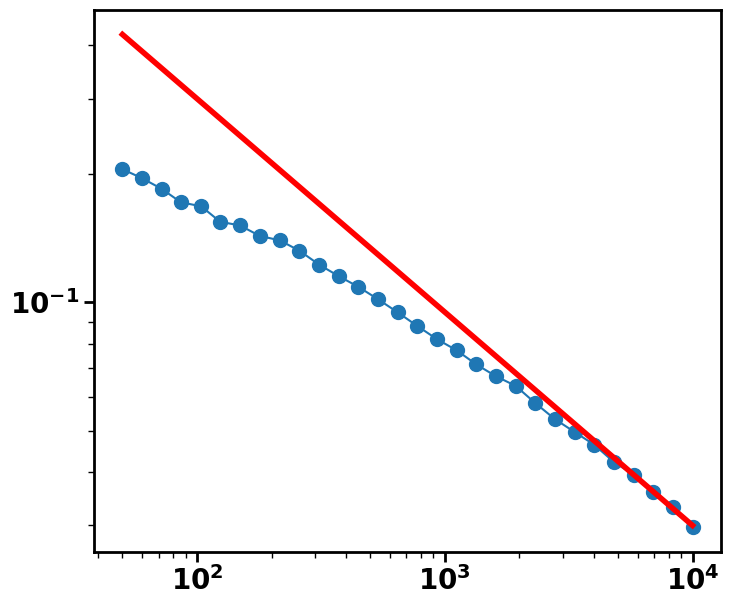

In [288]:
fig, ax = plot_loglog_rel_err(nums_Vs_for_tile, np.array([mean_difs]), plot_order_line=True)
ax = ax[0]
ax.tick_params(axis='x', which='major', length=7, width=2, direction='out')
ax.tick_params(axis='y', which='major', length=7, width=2, direction='out')
ax.tick_params(axis='x', which='minor', length=4, width=1, direction='out')
ax.tick_params(axis='y', which='minor', length=4, width=1, direction='out')

save_file_name = ("/Users/sidneyholden/repos/metric_graph/data/tiling/random_delaunay_triangulation_periodic" + 
                  "/uniform_delaunay_tiling_eigenfunction_relerr.png")

plt.savefig(save_file_name, dpi=200, bbox_inches='tight')